# EDA

In [1]:
# pip install pandas

In [2]:
# pip install matplotlib

In [3]:
# pip install seaborn 

In [4]:
# pip install pyarrow

#### IMPORT DES DONNEES

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\692205595.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
import pandas as pd
data = pd.read_csv("../SBAnational.csv", low_memory=False)
data = data.drop(['ChgOffDate', 'DisbursementDate', 'DisbursementGross','BalanceGross', 'ChgOffPrinGr'], axis=1)
data.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,2.0,0,0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


In [7]:
data_secteurs = pd.read_csv("../csv_secteursactivite.csv")
data_secteurs = data_secteurs.drop("Default rate (%)", axis=1)

# Modification de certaines valeurs 
mapping = {"31–33": "31", "44–45": "44", "48–49": "48"}
data_secteurs['2 digit code'] = data_secteurs['2 digit code'].replace(mapping)

# Création et Ajout de nouvelles lignes
nouvelles_lignes = [{'2 digit code': 32, 'Description': 'Manufacturing'},
                    {'2 digit code': 33, 'Description': 'Manufacturing'},
                    {'2 digit code': 45, 'Description': 'Retail trade'},
                    {'2 digit code': 49, 'Description': 'Transportation and warehousing'}]

# data_secteurs = data_secteurs.append(nouvelles_lignes, ignore_index=True)

# Concaténation
nouvelles_lignes_df = pd.DataFrame(nouvelles_lignes)
data_secteurs = pd.concat([data_secteurs, nouvelles_lignes_df], ignore_index=True)

# Conversion de la variable en int
data_secteurs["NAICS_id"] = data_secteurs["2 digit code"].astype(int)
data_secteurs = data_secteurs.drop("2 digit code", axis=1)
data_secteurs.head(5)


,Description,NAICS_id
0,"Mining, quarrying, and oil and gas extraction",21
1,"Agriculture, forestry, fishing and hunting",11
2,Management of companies and enterprises,55
3,Health care and social assistance,62
4,Utilities,22


### NETTOYAGE & PREPARATION DES DONNEES

In [8]:
# CONVERSION DES VARIABLES GrAppv ET SBA_Appv EN FORMAT FLOAT
def amount_to_float(s: str) -> float:
    """Converts a 'string' amount in $ to its float value"""
    return float(s[1:].replace(',', ''))

data["GrAppv"] = data["GrAppv"].apply(amount_to_float)
data["SBA_Appv"] = data["SBA_Appv"].apply(amount_to_float)

In [9]:
# CONVERSION DE LA VARIABLE ApprovalFY EN FORMAT INTEGER
def str_to_int(s: str) -> int:
    """Converts a 'string' digit into an integer and deletes string characters if necessary"""
    s = ''.join(char for char in str(s) if char.isdigit())
    return int(s) if s else None

data["ApprovalFY"] = data["ApprovalFY"].apply(str_to_int)

In [10]:
# CONVERSION DE LA VARIABLE ApprovalDate EN FORMAT DATETIME
# data['ApprovalDate'] = pd.to_datetime(data['ApprovalDate'], errors='coerce')
# data['ApprovalYear'] = data['ApprovalDate'].dt.year
# data['ApprovalMonth'] = data['ApprovalDate'].dt.month
# data['ApprovalDay'] = data['ApprovalDate'].dt.day
# data = data.drop("ApprovalDate", axis=1)
# data.head(1)


In [11]:
data.ApprovalDate = pd.to_datetime(data.ApprovalDate, format="%d-%b-%y")
data['ApprovalMonth'] = data.ApprovalDate.dt.month
data['ApprovalDay'] = data.ApprovalDate.dt.day
data['ApprovalDoW'] = data.ApprovalDate.dt.dayofweek
data.columns
data["ApprovalYear"] = data.ApprovalDate.dt.year
data = data.drop('ApprovalDate',axis=1)
#data[["ApprovalYear", "ApprovalMonth", "ApprovalDay", "ApprovalDoW"]]
data.ApprovalYear.describe()

count    899164.000000
mean       2000.913077
std           5.912140
min        1969.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2068.000000
Name: ApprovalYear, dtype: float64

In [12]:
def change_time(year):
    if 60 < year % 100 < 69:
        return year - 2000 + 1900  # Convert two-digit year to four-digit year
    return year

data["ApprovalYear"] = data["ApprovalYear"].apply(change_time)

In [13]:
data.ApprovalYear.describe()

count    899164.000000
mean       2000.912076
std           5.909548
min        1961.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalYear, dtype: float64

In [14]:
from datetime import datetime

# Updated recession periods with the COVID-19 pandemic recession
recession_periods = [
    (1969, 1970),
    (1973, 1975),
    (1980, 1980),
    (1981, 1982),
    (1990, 1991),
    (2001, 2001),
    (2007, 2009),
    (2020, 2020),  # Including the COVID-19 pandemic recession
]

# Function to check if a given year (from dt.year) was in recession
def is_year_in_recession(year):
    # The year parameter is expected to be an integer
    return any(start <= year <= end for start, end in recession_periods)

# Example usage of the function with datetime objects
current_year = datetime.now().year
# print(is_year_in_recession(current_year))  # Example: Check for the current year

data["Recession"] = data["ApprovalYear"].apply(is_year_in_recession)

In [15]:
# CREATION D'UNE AUTRE COLONNE NAICS 
data['NAICS_id'] = data['NAICS'].copy()
data['NAICS_id'] = data['NAICS_id'].astype(str).str[:2]
data['NAICS_id'] = data['NAICS_id'].astype('Int64')

# MERGE AVEC LE DATASET DES SECTEURS D'ACTIVITE
dataset = pd.merge(data, data_secteurs, on='NAICS_id', how='outer')

# SUPPRESSION DE LA COLONNE
# dataset = dataset.drop('NAICS_x', axis=1)
dataset = dataset.rename(columns={"NAICS_y" : "NAICS"})
dataset.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,MIS_Status,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,ApprovalDoW,ApprovalYear,Recession,NAICS_id,Description
0,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997,60,...,P I F,35000.0,28000.0,2,28,4,1997,False,0,NaN


In [16]:
# CREATION D'UNE COLONNE SameState POUR CAPTURER UNE RELATION ENTRE STATE DU CLIENT ET STATE DE LA BANK
dataset["SameState"] = (dataset['State'] == dataset['BankState']).astype(bool)

In [17]:
dataset = dataset.drop("LoanNr_ChkDgt", axis=1)
dataset.shape

(899164, 28)

In [18]:
# VALEURS NaN SUR TOUT LE DATASET
dataset_nan = dataset[dataset.isna().any(axis=1)]
len(dataset_nan)

209346

In [19]:
# DATASET OU LA TARGET EST REMPLIE DE NaN
MIS_nan = dataset[dataset["MIS_Status"].isna()]
len(MIS_nan)

1997

In [20]:
# CREATION D'UN DATASET SANS LES NaN DANS LA TARGET (il reste des NaN ailleurs qu'il faudra traiter)
dataframe = dataset[dataset["MIS_Status"].isna() == False]
len(dataframe)

897167

In [21]:
# TRANSFORMATION DES VALEURS NaN de NewExist EN 3 (catégorie non renseignée) ET CONVERSION DE LA VARIABLE EN INTEGER
# dataframe["NewExist"] = dataframe["NewExist"].fillna(3, axis=0).astype("Int64")
dataframe.loc[dataframe["NewExist"].isnull(), "NewExist"] = 0
dataframe["NewExist"] = dataframe["NewExist"].astype("Int64")

C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\2680347995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["NewExist"] = dataframe["NewExist"].astype("Int64")


In [22]:
# import dtale
# dtale.show(data)

In [23]:
dataframe.head(3)

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,...,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,ApprovalDoW,ApprovalYear,Recession,NAICS_id,Description,SameState
0,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997,60,2,...,35000.0,28000.0,2,28,4,1997,False,0,NaN,True
1,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997,240,14,...,229000.0,229000.0,2,28,4,1997,False,0,NaN,True
2,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,1980,45,45,...,600000.0,499998.0,6,2,0,1980,True,0,NaN,False


In [24]:
dataframe.NAICS.value_counts()

NAICS
0         201667
722110     27941
722211     19435
811111     14539
621210     14034
           ...  
311311         1
312210         1
316212         1
313310         1
922140         1
Name: count, Length: 1312, dtype: int64

### SWEETVIZ

In [25]:
# pip install sweetviz

In [26]:
# import sweetviz as sv
# #dataframe = dataframe.dropna()
# dataset['ApprovalFY'] = pd.to_numeric(dataset['ApprovalFY'], errors='coerce').astype('Int64')
# dataset = dataset.dropna()
# my_report = sv.analyze(data)
# my_report.show_html()

### YDATA

In [27]:
# pip install pandas-profiling

In [28]:
# pip install jupyter

In [29]:
# pip install ipywidgets

In [30]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(data, title="Profiling Report")
# profile

### EDA ANALYSE UNIVARIEE

#### NAME 

In [31]:
dataset.Name.describe()

count     899150
unique    779583
top       SUBWAY
freq        1269
Name: Name, dtype: object

In [32]:
filtre = dataset.Name.value_counts() == 1
filtre.value_counts()

count
True     706468
False     73115
Name: count, dtype: int64

In [33]:
dataset.Name.isnull().sum()
# ON REMPLACE CES VALEURS OU ON LES SUPPR?

14

In [34]:
# CONCLUSION : VARIABLE A SUPPRIMER
# CREER UNE NOUVELLE VARIABLE (UN PRET OU PLUSIEURS PRETS)

#### CITY

In [35]:
dataframe.City.describe()

count          897137
unique          32566
top       LOS ANGELES
freq            11550
Name: City, dtype: object

In [36]:
dataframe.City.isnull().sum()

30

In [37]:
dataframe.City.value_counts()

City
LOS ANGELES              11550
HOUSTON                  10229
NEW YORK                  7834
CHICAGO                   6009
MIAMI                     5594
                         ...  
ROBERTSON                    1
NONTROSE                     1
WINSLOW TWNSHP               1
DUBOISTOWN                   1
HENDERSON (CLARK CTY)        1
Name: count, Length: 32566, dtype: int64

In [38]:
# Suppression ou Remplacement des valeurs manquantes?
# A voir avec ZIP > on va sûrement garder ZIP pour le modèle et suppr cette variable City

In [39]:
# TOP 20 des Villes (Count=Nb de demandes de prêts)
dataframe.groupby("City").count().sort_values(by="Name", ascending=False).head(10)
top10_city = dataframe.groupby("City").count().sort_values(by="Name", ascending=False).reset_index()
top10_city = top10_city[["City", "Name"]]
top10_city = top10_city.rename(columns={"Name" : "Total_Loan_Applications"})
top10_city.head(20)

,City,Total_Loan_Applications
0,LOS ANGELES,11550
1,HOUSTON,10228
2,NEW YORK,7834
3,CHICAGO,6009
4,MIAMI,5594
5,SAN DIEGO,5359
6,DALLAS,5084
7,PHOENIX,4490
8,LAS VEGAS,4388
9,SPRINGFIELD,3728


C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\935955263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(test_top, x='City', y="Total", palette="Greens_r")


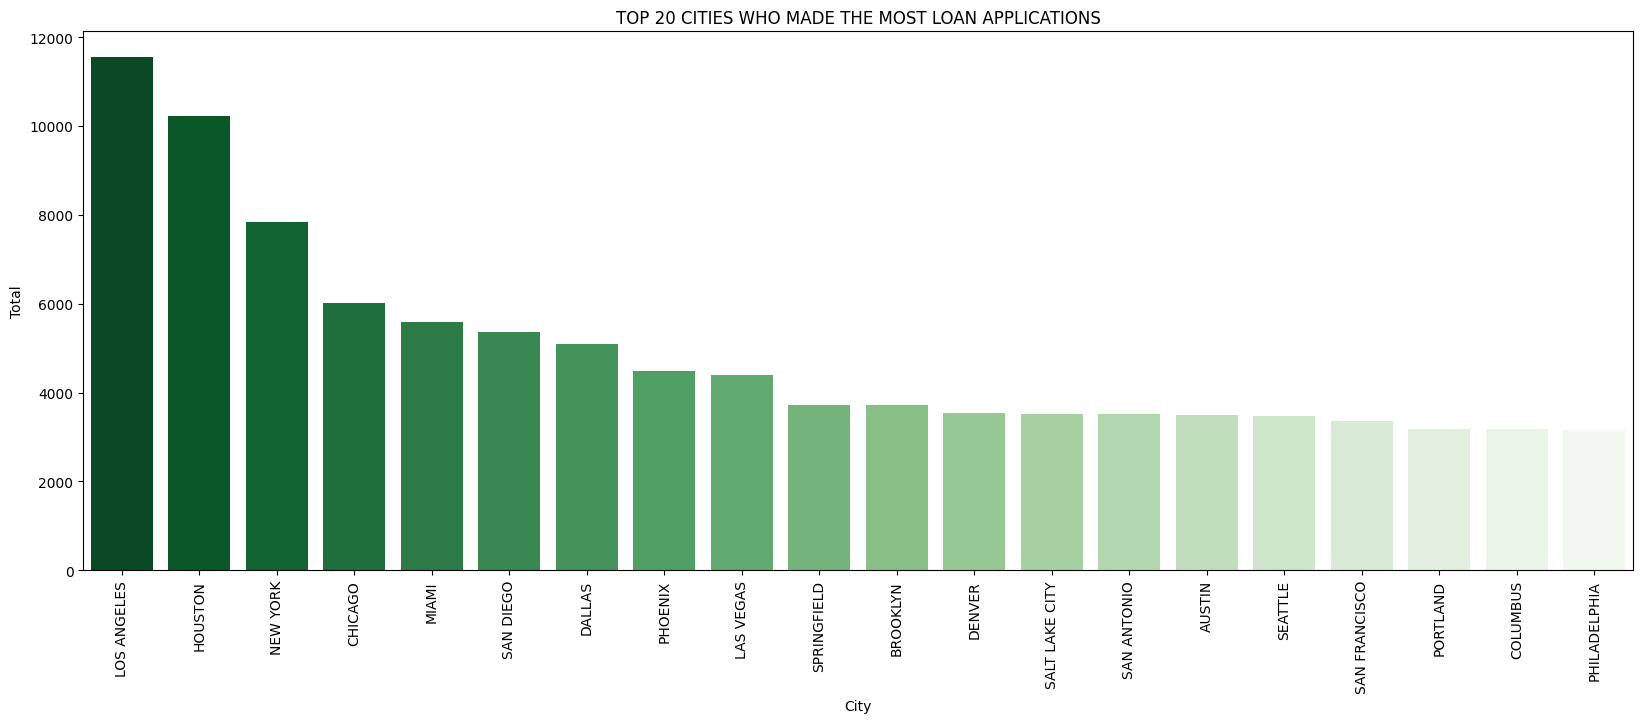

In [40]:
test = dataframe.groupby("City").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False).head(20)
test_top = test_top[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_top, x='City', y="Total", palette="Greens_r")
plt.xticks(rotation='vertical')
plt.show()

C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\4161583242.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(test_flop, x='City', y="Total", palette="Reds_r")


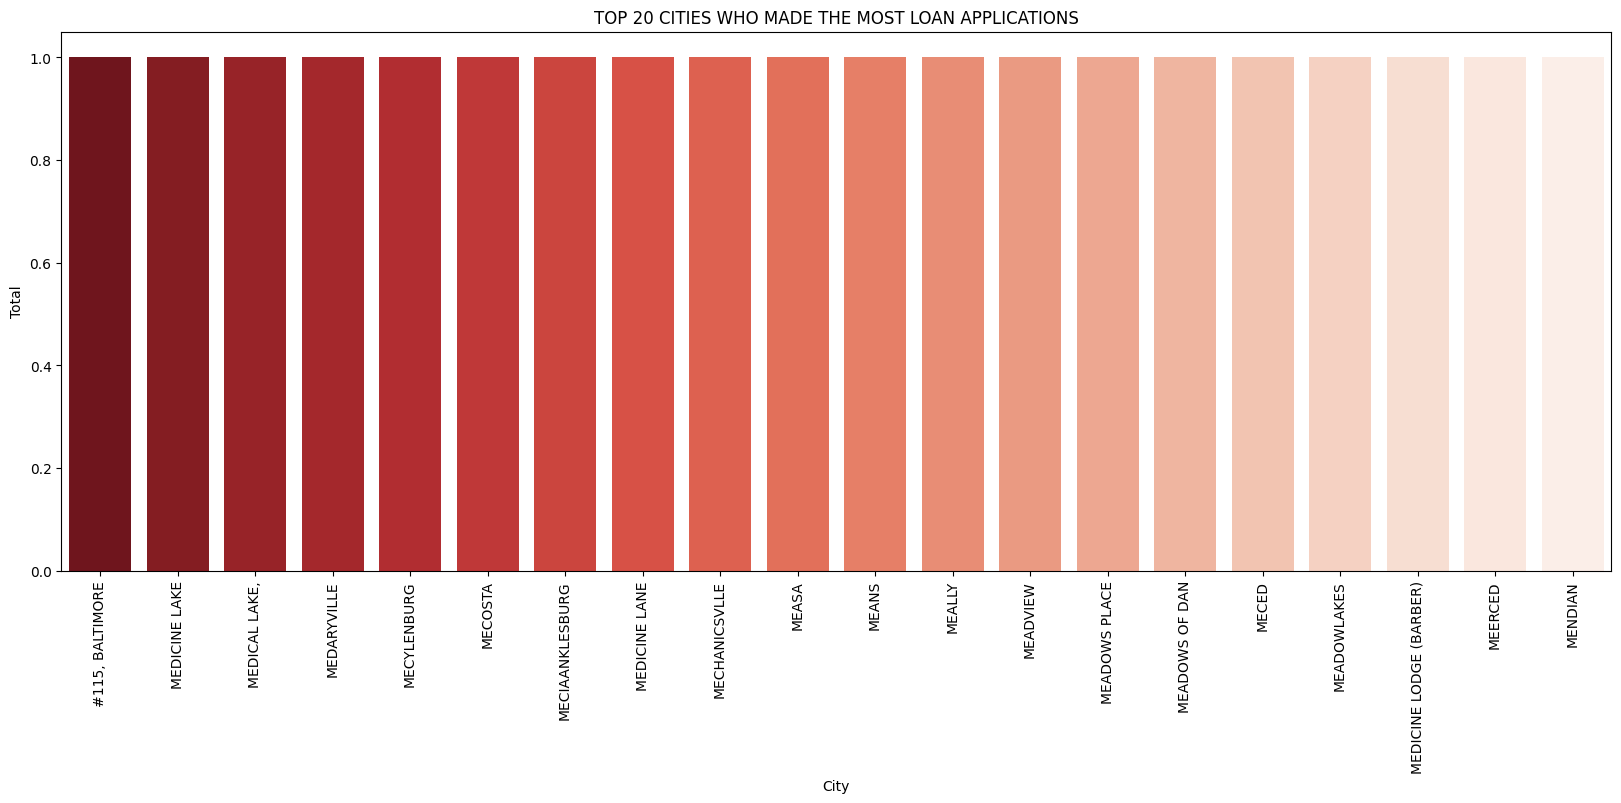

In [41]:
test_flop = test.sort_values(by="Total", ascending=True).head(20)
test_flop = test_flop[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_flop, x='City', y="Total", palette="Reds_r")
plt.xticks(rotation='vertical')
plt.show()

In [42]:
# ON PEUT REGROUPER PAR ANNEE AUSSI

In [43]:
test2 = dataframe.groupby(["City", "ApprovalYear"]).count().reset_index()
test2 = test2.sort_values(by="Name", ascending=False)
test2.head(20)

,City,ApprovalYear,Name,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,MIS_Status,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,ApprovalDoW,Recession,NAICS_id,Description,SameState
85687,LOS ANGELES,2004,1501,1501,1501,1501,1501,1501,1501,1501,...,1501,1501,1501,1501,1501,1501,1501,1501,1501,1501
85690,LOS ANGELES,2007,1312,1312,1312,1312,1312,1312,1312,1312,...,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312
85686,LOS ANGELES,2003,1236,1236,1236,1236,1236,1236,1236,1236,...,1236,1236,1236,1236,1236,1236,1236,1236,1236,1236
85689,LOS ANGELES,2006,1014,1014,1014,1014,1014,1014,1014,1014,...,1014,1014,1014,1014,1014,1014,1014,1014,1014,1014
105311,NEW YORK,2004,1007,1007,1007,1007,1007,1007,1007,1007,...,1007,1007,1007,1007,1007,1007,1007,1007,1007,1007
85688,LOS ANGELES,2005,984,984,984,984,984,984,984,984,...,984,984,984,984,984,984,984,984,984,984
105313,NEW YORK,2006,940,940,940,940,940,940,940,940,...,940,940,940,940,940,940,940,940,940,940
68632,HOUSTON,2006,916,916,916,916,916,916,916,916,...,916,916,916,916,916,916,916,916,916,916
68630,HOUSTON,2004,899,899,899,899,899,899,899,899,...,899,899,899,899,899,899,899,899,899,899
25876,CHICAGO,2006,884,884,884,884,884,884,884,884,...,884,884,884,884,884,884,884,884,884,884


In [44]:
dataframe.ApprovalYear.describe()

count    897167.000000
mean       2000.908150
std           5.908121
min        1966.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalYear, dtype: float64

In [45]:
# SUPPRESSION DE LA VARIABLE "CITY"
dataframe = dataframe.drop("City", axis=1)

#### STATE

In [46]:
dataframe.State.describe()

count     897154
unique        51
top           CA
freq      130488
Name: State, dtype: object

In [47]:
dataframe.State.isnull().sum()

13

In [48]:
# Valeurs manquantes à REMPLACER ou SUPPRIMER
dataframe.query("State.isna()")

,Name,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,...,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,ApprovalDoW,ApprovalYear,Recession,NAICS_id,Description,SameState
8492,TRYON COATS & LEATHER,NaN,0,KEYBANK NATIONAL ASSOCIATION,NY,0,1966,282,0,0,...,60000.0,54000.0,5,18,1,1966,False,0,NaN,False
50163,CENTURY 21 PHILLIPS REALTY,NaN,95682,SBA - EDF ENFORCEMENT ACTION,CO,0,1987,240,19,1,...,83000.0,83000.0,2,12,3,1987,False,0,NaN,False
73611,CASCO SERVICE,NaN,54205,UNION STATE BANK,WI,0,1990,204,8,1,...,300000.0,252600.0,10,19,3,1989,False,0,NaN,False
73876,P & P TOOL INC,NaN,54025,FIRST BANK OF BALDWIN,WI,0,1990,240,7,1,...,82000.0,73800.0,10,26,3,1989,False,0,NaN,False
195080,"VERANDA INTERIORS, INC.",NaN,76645,PROSPERITY BANK,TX,0,1997,120,3,1,...,100000.0,80000.0,10,24,3,1996,False,0,NaN,False
278698,"OLSON ELECTRIC SERVICE, INC.",NaN,75236,PROSPERITY BANK,TX,235310,1996,60,17,1,...,40000.0,32000.0,7,9,1,1996,False,23,Construction,False
278789,METRO SHEETMETAL & ERECTION,NaN,76052,PROSPERITY BANK,TX,235610,1996,84,3,1,...,80000.0,64000.0,7,23,1,1996,False,23,Construction,False
432301,WILLIAMS JEWELERS,NaN,84124,ZIONS FIRST NATIONAL BANK,UT,448310,1990,60,4,1,...,250000.0,212500.0,12,14,3,1989,False,44,Retail trade,False
499130,"GOLF SHOES UNLIMITED, INC.",NaN,33410,"BEAL BANK, SSB",TX,451110,1990,84,3,2,...,75000.0,67500.0,10,19,3,1989,False,45,Retail trade,False
574370,JAMES A. NICHOLS,NaN,79925,WELLS FARGO BANK NATL ASSOC,TX,532230,1989,16,1,2,...,60000.0,54000.0,5,19,4,1989,False,53,Real estate and rental and leasing,False


C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\427930818.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(test_top, x='State', y="Total", palette="Blues_r")


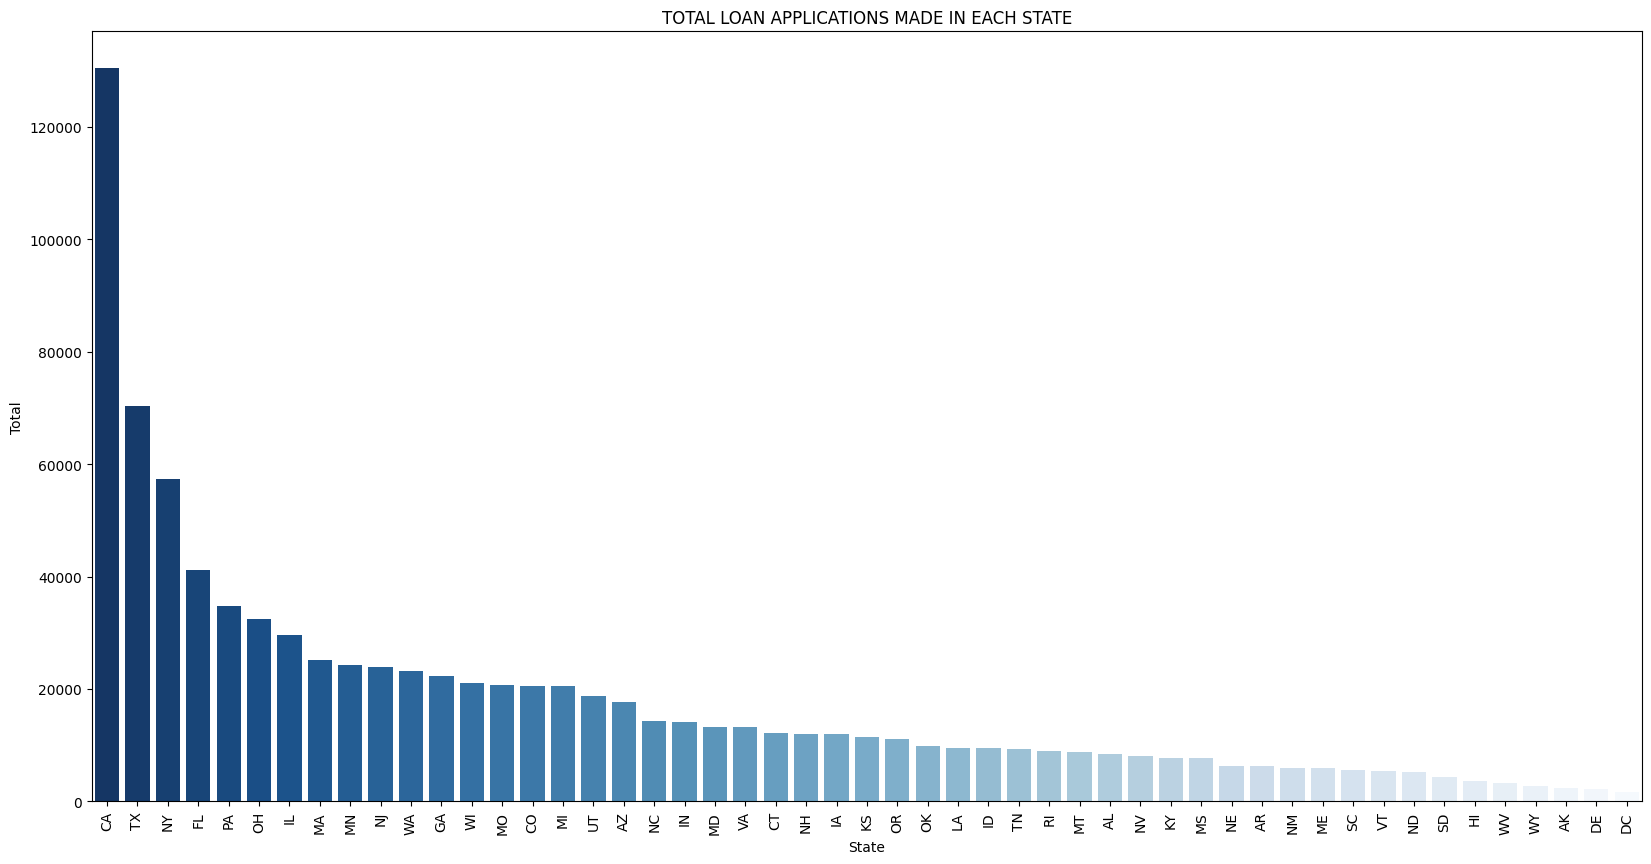

In [49]:
test = dataframe.groupby("State").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False)
test_top = test_top[["State", "Total"]]
plt.figure(figsize=(20,10))
plt.title("TOTAL LOAN APPLICATIONS MADE IN EACH STATE")
sns.barplot(test_top, x='State', y="Total", palette="Blues_r")
plt.xticks(rotation='vertical')
plt.grid(False)
plt.show()

#### ZIP

In [50]:
dataframe.Zip.isnull().sum()

0

In [51]:
dataframe.Zip.describe()

count    897167.000000
mean      53856.710734
std       31170.471151
min           0.000000
25%       27612.000000
50%       55416.000000
75%       83706.000000
max       99999.000000
Name: Zip, dtype: float64

In [52]:
dataframe = dataframe.drop(columns="Zip")

#### BANK

In [53]:
dataframe.Bank.describe()

count                         895661
unique                          5801
top       BANK OF AMERICA NATL ASSOC
freq                           86773
Name: Bank, dtype: object

In [54]:
# QUE FAIRE DES NaN?
dataframe.Bank.isnull().sum()

1506

In [55]:
filtre = dataframe.Bank.value_counts() > 1
filtre.value_counts()

count
True     4878
False     923
Name: count, dtype: int64

In [56]:
dataframe.Bank = dataframe.Bank.fillna("MISSING")
dataframe.Bank.value_counts()

Bank
BANK OF AMERICA NATL ASSOC        86773
WELLS FARGO BANK NATL ASSOC       63461
JPMORGAN CHASE BANK NATL ASSOC    48131
U.S. BANK NATIONAL ASSOCIATION    35112
CITIZENS BANK NATL ASSOC          33770
                                  ...  
THOMAS CNTY FED. S & L ASSOC          1
CAPITAL BANK CORPORATION              1
AURGROUP FINANCIAL CU                 1
HAWTHORN BANCSHARES, INC              1
ALLIANCE BK OF ARIZONA A DIVIS        1
Name: count, Length: 5802, dtype: int64

#### BANKSTATE

In [57]:
dataframe.BankState.describe()

count     895654
unique        56
top           CA
freq      118034
Name: BankState, dtype: object

In [58]:
# QUE FAIRE DES NaN?
# REMPLACER LES VALEURS NAN PAR "MISSING" (BANQUES ETRANGERES)
dataframe.BankState.isnull().sum()
dataframe.BankState = dataframe.BankState.fillna("MISSING")
dataframe.BankState.value_counts()

BankState
CA         118034
NC          79455
IL          65864
OH          58430
SD          51065
TX          47761
RI          44117
NY          39546
VA          28960
DE          24524
MN          19950
UT          18994
PA          17050
WI          15404
MO          14844
MA          13845
GA          13805
FL          13803
AL          12128
OR          11373
WA          10689
CO          10580
CT           9907
IA           9860
NJ           9434
KS           8869
MT           7848
IN           7619
SC           7471
MI           7366
OK           7322
MD           6995
NH           6794
AR           6311
MS           5924
TN           5619
NE           5336
ND           5104
LA           5057
VT           4751
NM           4416
KY           4380
NV           4323
ID           4314
DC           4003
AZ           3957
ME           3689
HI           2989
WY           2167
WV           2006
MISSING      1513
AK           1439
PR            155
GU              5
EN              1


In [59]:
dataframe.query("BankState.isna()")

,Name,State,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,ApprovalDoW,ApprovalYear,Recession,NAICS_id,Description,SameState


In [60]:
test = dataframe.query("BankState.isna()")
test.Bank.value_counts()

Series([], Name: count, dtype: int64)

#### NAICS (aka : Description & NAICS_id)

In [61]:
dataframe.Description.isnull().sum()

201667

In [62]:
dataframe.Description.value_counts()

Description
Retail trade                                                     126975
Other services (except public administration)                     72395
Professional, scientific, and technical services                  67922
Manufacturing                                                     67903
Accommodation and food services                                   67511
Construction                                                      66492
Health care and social assistance                                 55264
Wholesale trade                                                   48673
Administrative/support & waste management/remediation Service     32529
Transportation and warehousing                                    22408
Arts, entertainment, and recreation                               14616
Real estate and rental and leasing                                13588
Information                                                       11362
Finance and insurance                               

In [63]:
dataframe.Description = dataframe.Description.fillna("Unknown")

In [64]:
#dataframe.query("Description.isna()")
dataframe.Description.value_counts()

Description
Unknown                                                          201667
Retail trade                                                     126975
Other services (except public administration)                     72395
Professional, scientific, and technical services                  67922
Manufacturing                                                     67903
Accommodation and food services                                   67511
Construction                                                      66492
Health care and social assistance                                 55264
Wholesale trade                                                   48673
Administrative/support & waste management/remediation Service     32529
Transportation and warehousing                                    22408
Arts, entertainment, and recreation                               14616
Real estate and rental and leasing                                13588
Information                                         

C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\1871991612.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(test_top, x='Description', y="Total", palette="Purples_r")


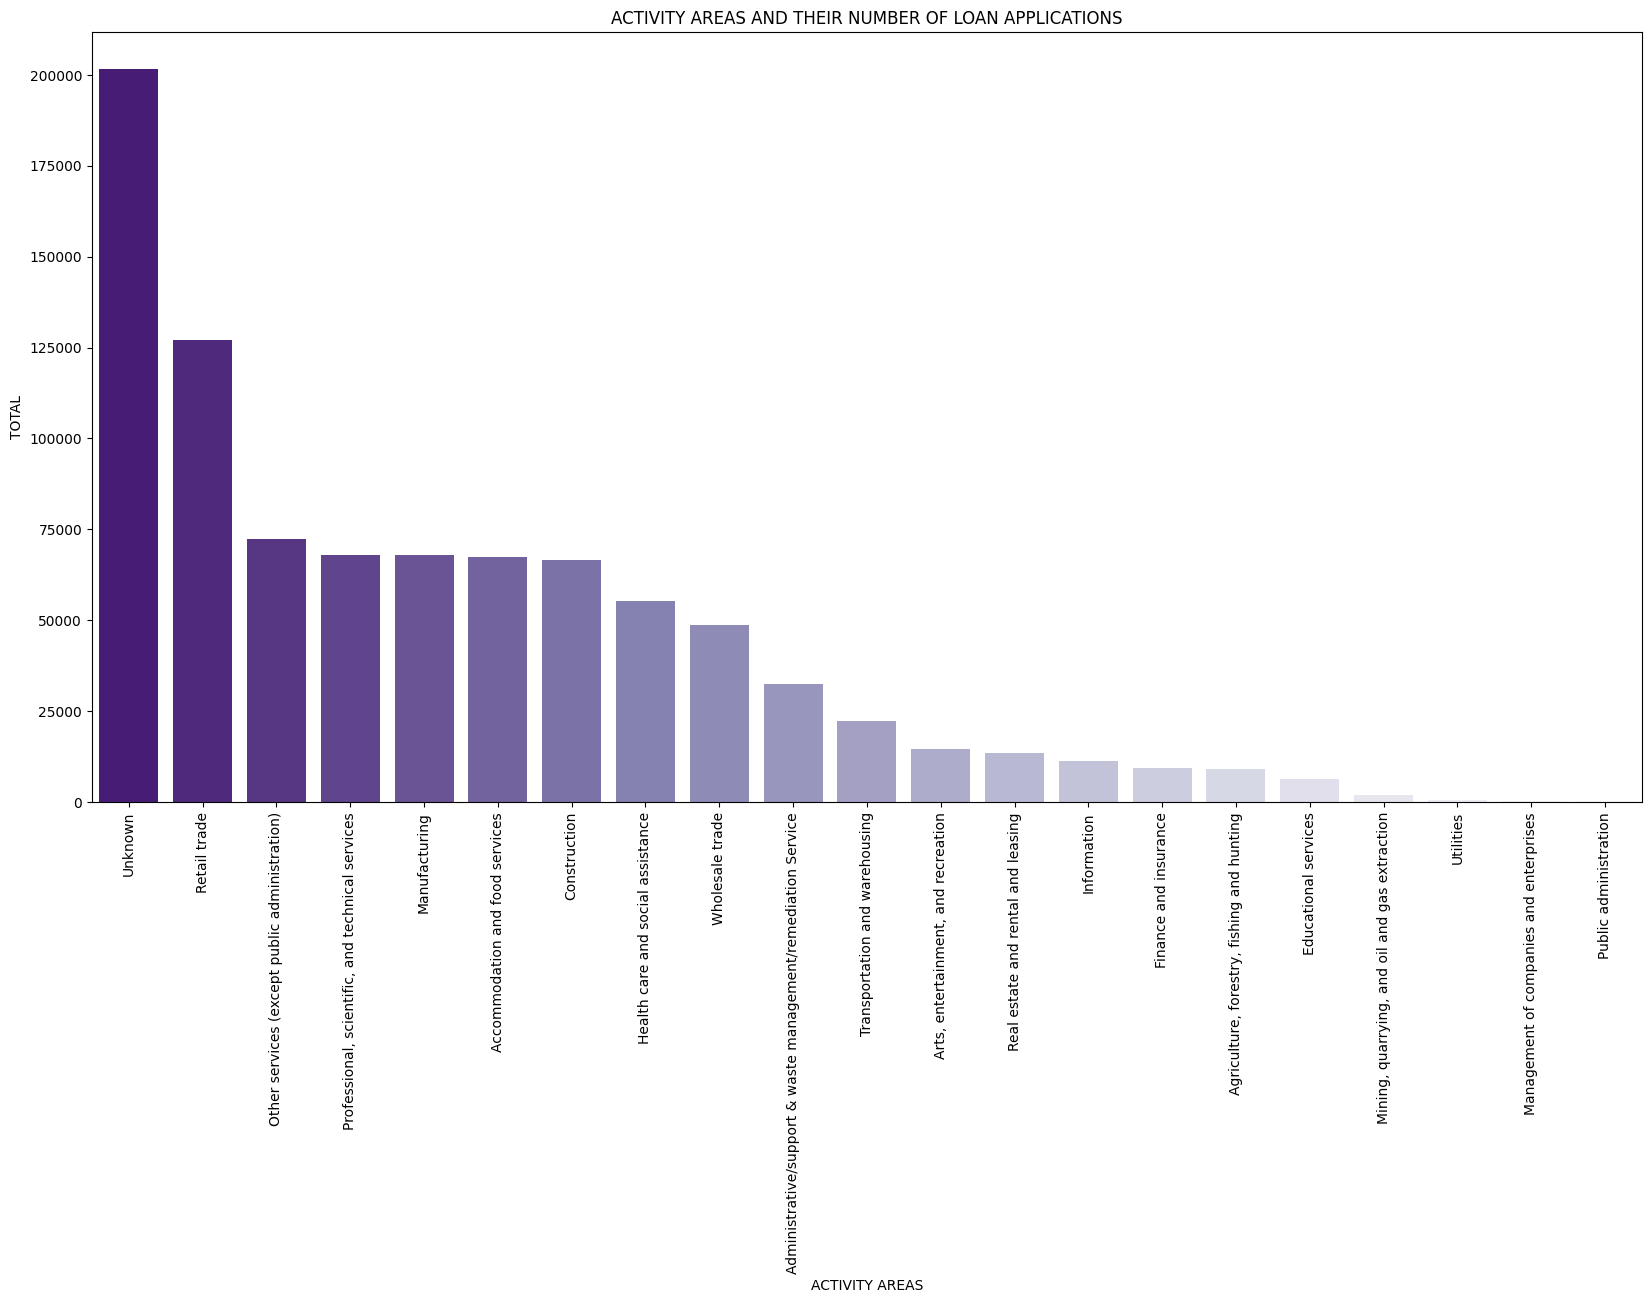

In [65]:
test = dataframe.groupby("Description").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False)
test_top = test_top[["Description", "Total"]]
plt.figure(figsize=(20,10))
plt.title("ACTIVITY AREAS AND THEIR NUMBER OF LOAN APPLICATIONS")
sns.barplot(test_top, x='Description', y="Total", palette="Purples_r")
plt.xticks(rotation='vertical')
plt.xlabel("ACTIVITY AREAS")
plt.ylabel("TOTAL")
plt.show()

In [66]:
dataframe.NAICS_id.isnull().sum()

0

#### ApprovalDate = ApprovalYear, ApprovalMonth, ApprovalDay

In [67]:
dataframe.ApprovalYear.describe()

count    897167.000000
mean       2000.908150
std           5.908121
min        1966.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalYear, dtype: float64

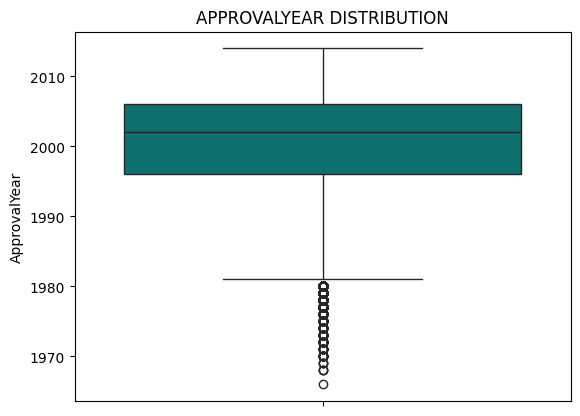

In [152]:
sns.boxplot(dataframe.ApprovalYear, color="teal")
plt.title("APPROVALYEAR DISTRIBUTION")
plt.show()

In [69]:
dataframe.ApprovalMonth.describe()

count    897167.000000
mean          6.483538
std           3.361659
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: ApprovalMonth, dtype: float64

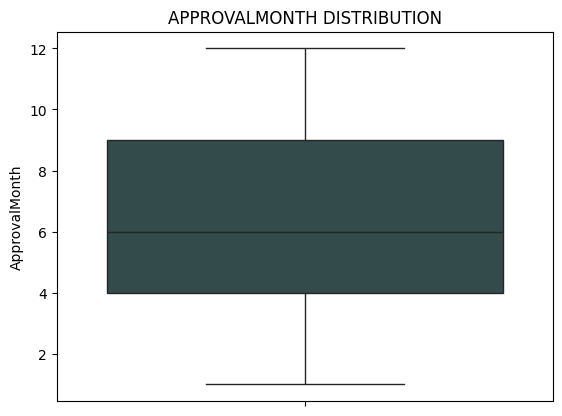

In [150]:
sns.boxplot(dataframe.ApprovalMonth, color='darkslategrey')
plt.title("APPROVALMONTH DISTRIBUTION")
plt.show()

In [71]:
dataframe.ApprovalDay.describe()

count    897167.000000
mean         16.188073
std           8.763399
min           1.000000
25%           9.000000
50%          16.000000
75%          24.000000
max          31.000000
Name: ApprovalDay, dtype: float64

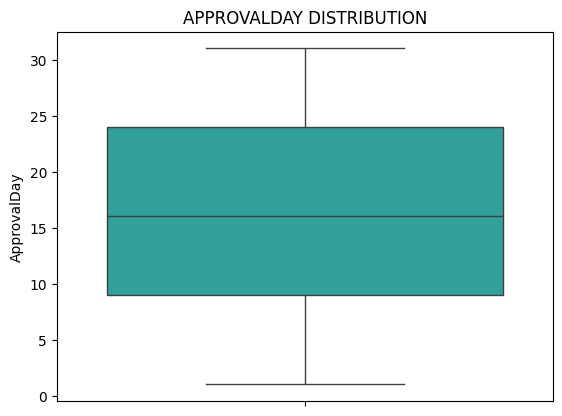

In [149]:
sns.boxplot(dataframe.ApprovalDay, color='lightseagreen')
plt.title("APPROVALDAY DISTRIBUTION")
plt.show()

In [73]:
# 0 NaN dans les 3 variables
dataframe.ApprovalDay.isnull().sum()

0

#### ApprovalFY

In [74]:
dataframe.ApprovalFY.isnull().sum()

0

In [75]:
dataframe.ApprovalFY.describe()

count    897167.000000
mean       2001.139677
std           5.912461
min        1966.000000
25%        1997.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalFY, dtype: float64

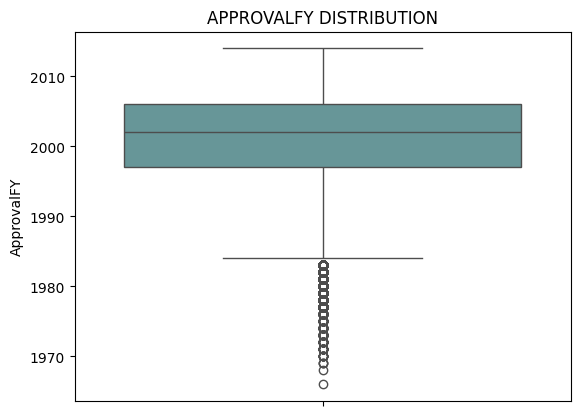

In [148]:
sns.boxplot(dataframe.ApprovalFY, color='cadetblue')
plt.title("APPROVALFY DISTRIBUTION")
plt.show()

#### Term

In [77]:
dataframe.Term.isnull().sum()

0

In [78]:
dataframe.Term.describe()

count    897167.000000
mean        110.848592
std          78.900862
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

In [79]:
test = dataframe.query("Term == 0")
test.MIS_Status.value_counts()

MIS_Status
CHGOFF    734
P I F      72
Name: count, dtype: int64

In [80]:
calcul = 569/12
calcul

47.416666666666664

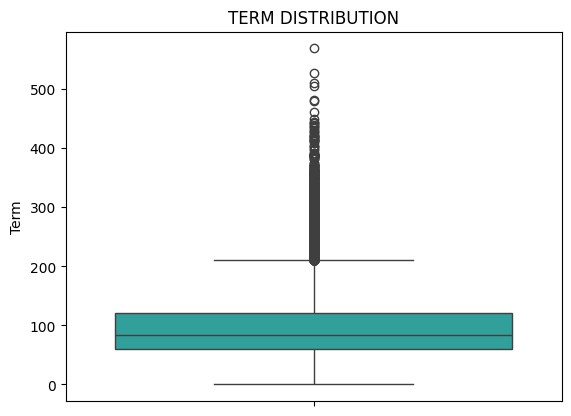

In [147]:
sns.boxplot(dataframe.Term, color='lightseagreen')
plt.title("TERM DISTRIBUTION")
plt.show()

#### NoEmp

In [82]:
dataframe.NoEmp.isnull().sum()

0

In [83]:
dataframe.NoEmp.describe()

count    897167.000000
mean         11.412562
std          73.793775
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        9999.000000
Name: NoEmp, dtype: float64

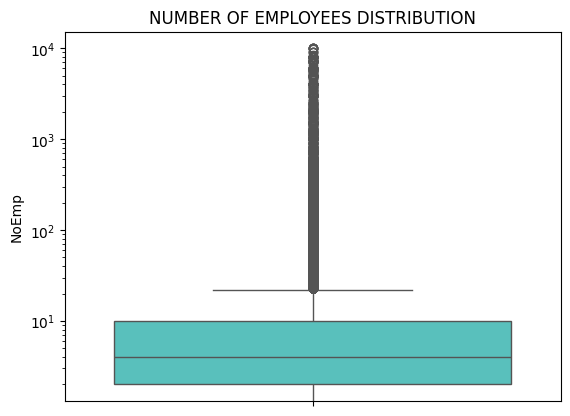

In [146]:
sns.boxplot(dataframe.NoEmp, color='mediumturquoise')
plt.title("NUMBER OF EMPLOYEES DISTRIBUTION")
plt.yscale('log')
plt.show()

#### NewExist

In [138]:
dataframe.NewExist.value_counts(dropna=False)
# REMPLACER 2 PAR TRUE ET TOUT LE RESTE PAR FALSE (VOIR NOTEBOOK GREG)
def encode_NewExist(x: float) -> bool:
    if x > 1.5:
        return True
    return False
dataframe.NewExist = dataframe.NewExist.map(encode_NewExist)

In [86]:
# Séparer le dataframe en deux (deux (ou trois) variables de NewExist)
# Faire un boxplot pour chaque valeur de NewExist
# Faire un pie-plot pour montrer le %

In [87]:
# Mettre les (3) dans (0)
dataframe.NewExist.replace(3, 1, inplace=True)

C:\Users\Thibaut\AppData\Local\Temp\ipykernel_7088\1409498457.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe.NewExist.replace(3, 1, inplace=True)


In [88]:
dataframe.NewExist.isnull().sum()

0

In [143]:
dataframe.NewExist.value_counts()

NewExist
False    644608
True     252559
Name: count, dtype: int64

In [89]:
# Séparer le dataframe en deux (deux (ou trois) variables de NewExist)

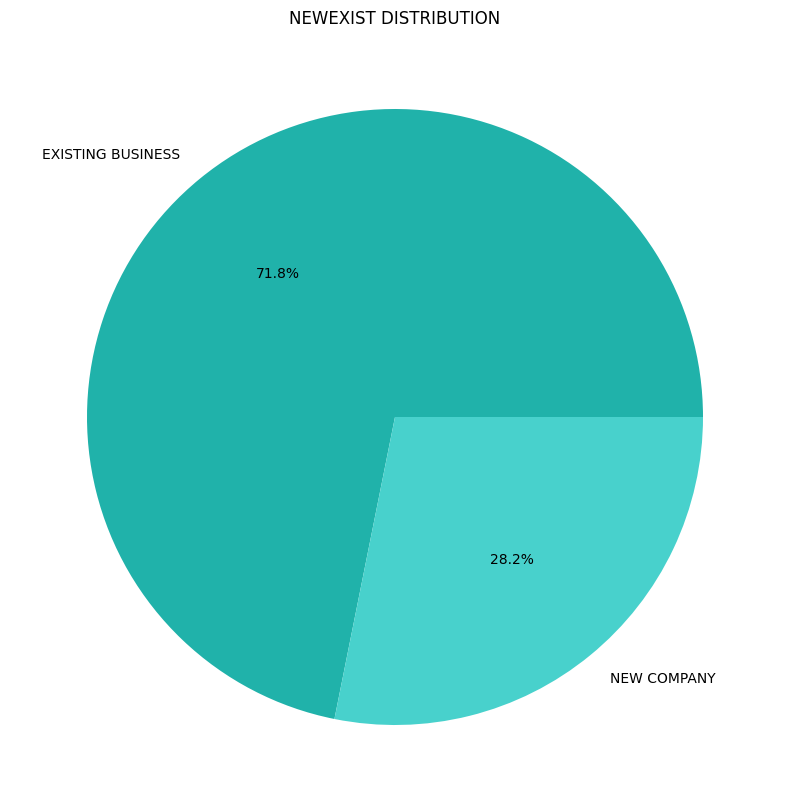

In [163]:
colors = ["lightseagreen",  "mediumturquoise"]
labels = ["EXISTING BUSINESS", "NEW COMPANY"]
plt.figure(figsize=(10, 10))
plt.pie(dataframe.NewExist.value_counts(), colors=colors, labels=labels, autopct='%1.1f%%')
plt.title("NEWEXIST DISTRIBUTION")
plt.show()

#### CreateJob

In [91]:
dataframe.CreateJob.describe()

count    897167.000000
mean          8.444305
std         236.950249
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        8800.000000
Name: CreateJob, dtype: float64

In [92]:
dataframe.CreateJob.isnull().sum()

0

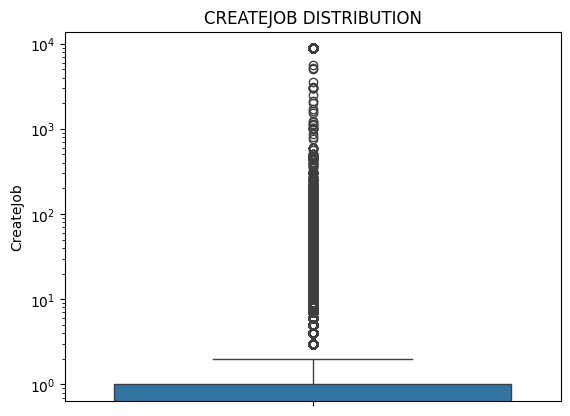

In [93]:
sns.boxplot(dataframe.CreateJob)
plt.yscale('log')
plt.title("CREATEJOB DISTRIBUTION")
plt.show()

#### RetainedJob

In [94]:
dataframe.RetainedJob.describe()

count    897167.000000
mean         10.807308
std         237.382398
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max        9500.000000
Name: RetainedJob, dtype: float64

In [95]:
dataframe.RetainedJob.isnull().sum()

0

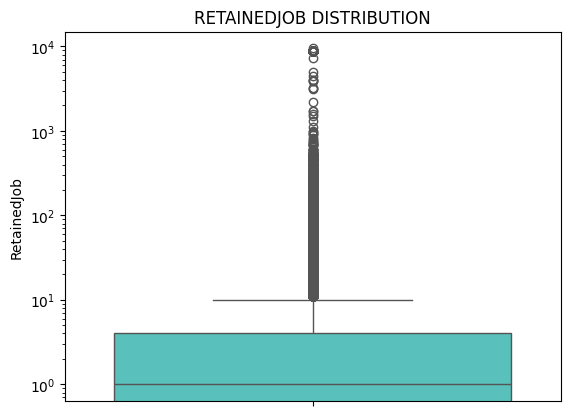

In [96]:
sns.boxplot(dataframe.RetainedJob, color="mediumturquoise")
plt.yscale('log')
plt.title("RETAINEDJOB DISTRIBUTION")
plt.show()

#### FranchiseCode

In [97]:
dataframe.FranchiseCode.describe()

count    897167.000000
mean       2757.528287
std       12767.025962
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       99999.000000
Name: FranchiseCode, dtype: float64

In [98]:
dataframe.FranchiseCode.isnull().sum()

0

In [99]:
dataframe.FranchiseCode.value_counts()

FranchiseCode
1        637395
0        208040
78760      3373
68020      1921
50564      1034
          ...  
45477         1
89782         1
4456          1
77387         1
25825         1
Name: count, Length: 2767, dtype: int64

In [100]:
# Faire un pie chart avec % franchisés et % non-franchisés
# Binariser la variable (0 et 1 = non franchisés, autre nombres = franchisé)

#### UrbanRural

In [101]:
dataframe.UrbanRural.describe()

count    897167.000000
mean          0.757274
std           0.646540
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: UrbanRural, dtype: float64

In [102]:
dataframe.UrbanRural.isnull().sum()

0

In [103]:
dataframe.UrbanRural.value_counts()

UrbanRural
1    469281
0    322826
2    105060
Name: count, dtype: int64

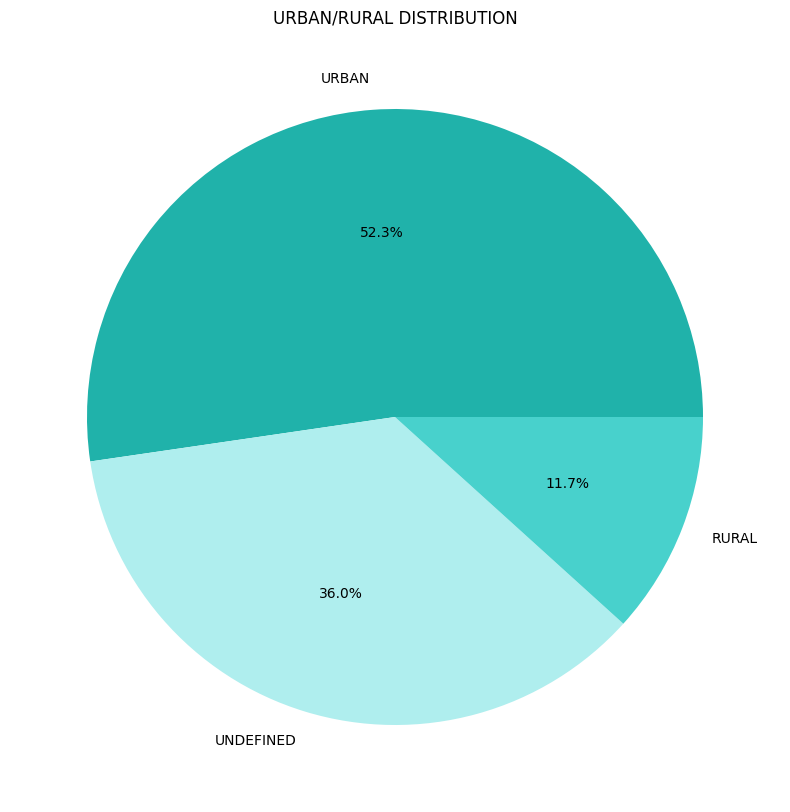

In [104]:
plt.figure(figsize=(10,10))
labels = ["URBAN", "UNDEFINED", "RURAL"]
colors = ["lightseagreen", "paleturquoise", "mediumturquoise"]
plt.title("URBAN/RURAL DISTRIBUTION")
plt.pie(dataframe.UrbanRural.value_counts(), labels=labels, colors=colors, autopct='%1.1f%%')
plt.show()

In [105]:
# MODIFICATION DES VALEURS DE LA VARIABLE UrbanRural
mapping = {0: "M", 1: "U", 2: "R"}
dataframe["UrbanRural"] = dataframe["UrbanRural"].map(mapping)
dataframe.UrbanRural.value_counts()

UrbanRural
U    469281
M    322826
R    105060
Name: count, dtype: int64

#### RevLineCR & LowDoc

In [106]:
dataframe.RevLineCr.describe()

count     892647
unique        18
top            N
freq      419252
Name: RevLineCr, dtype: object

In [107]:
dataframe.RevLineCr.isnull().sum()

4520

In [108]:
dataframe.RevLineCr.value_counts()

RevLineCr
N    419252
0    257431
Y    200660
T     15239
1        23
R        14
`        11
2         6
C         2
,         1
-         1
A         1
Q         1
4         1
.         1
5         1
3         1
7         1
Name: count, dtype: int64

In [109]:
def change(value):
    if value != "N" and value != "Y":
        return "UNKNOWN"
    return value

dataframe["RevLineCr"] = dataframe["RevLineCr"].apply(change)
dataframe.RevLineCr.value_counts()

RevLineCr
N          419252
UNKNOWN    277255
Y          200660
Name: count, dtype: int64

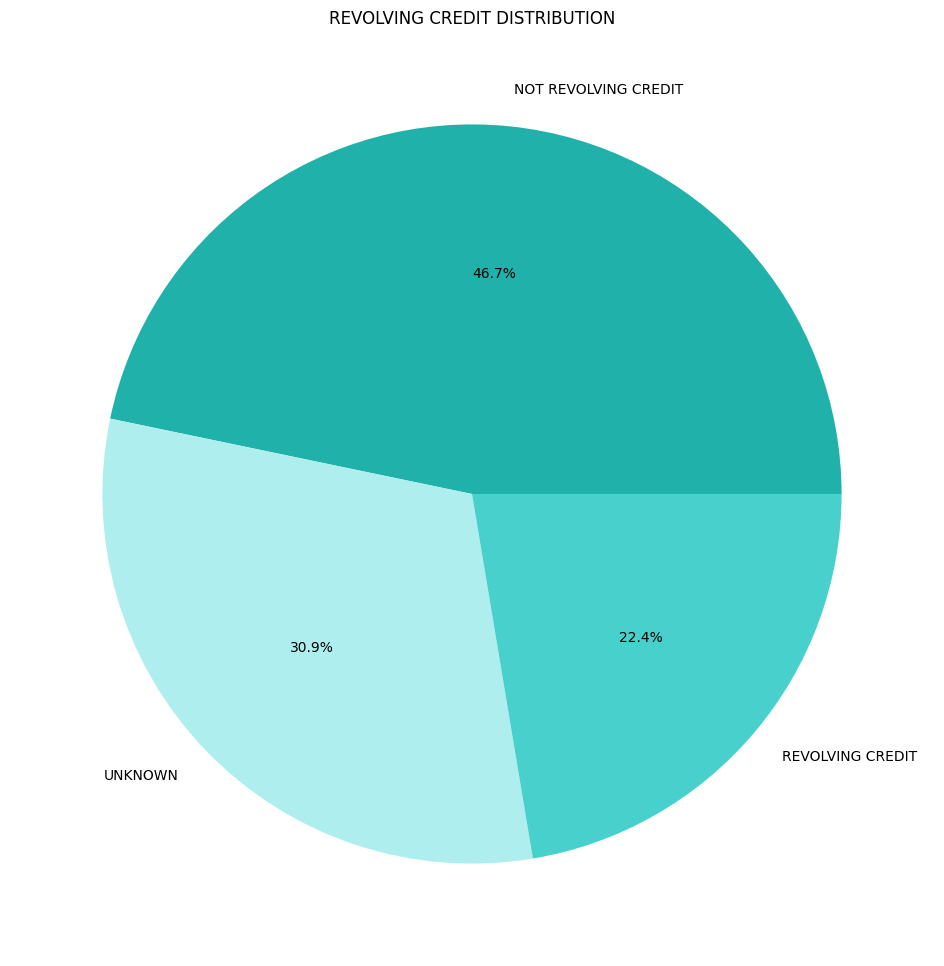

In [110]:
labels = ["NOT REVOLVING CREDIT", "UNKNOWN", "REVOLVING CREDIT"]
colors = ["lightseagreen", "paleturquoise", "mediumturquoise"]
plt.figure(figsize=(12,12))
plt.pie(dataframe.RevLineCr.value_counts(), labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("REVOLVING CREDIT DISTRIBUTION")
plt.show()

In [111]:
# Mettre les valeurs bizarres de LowDoc dans Y (YES)
# Prendre la fonction sur notebook Greg

In [112]:
def encode_LowDoc(s: "object") -> str:
    if s == "N":
        return s
    return "Y"

dataframe.LowDoc = dataframe.LowDoc.map(encode_LowDoc)
dataframe.LowDoc.value_counts()

LowDoc
N    780997
Y    116170
Name: count, dtype: int64

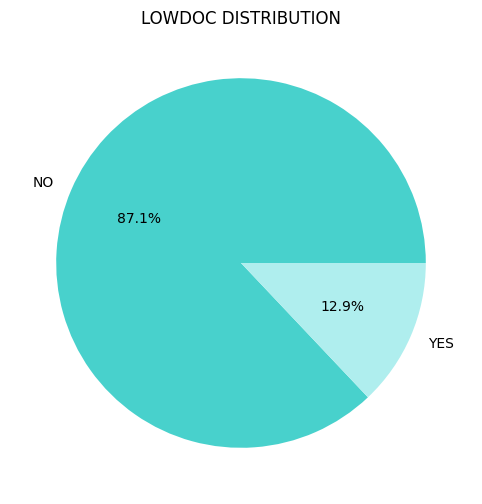

In [155]:
# PIE CHART A FAIRE POUR LOWDOC
labels = ["NO", "YES"]
colors = ["paleturquoise", "mediumturquoise"]
plt.figure(figsize=(10,6))
plt.pie(dataframe.LowDoc.value_counts().head(2), autopct='%1.1f%%', colors=colors, labels=labels)
plt.title("LOWDOC DISTRIBUTION")
plt.show()

#### GrAppv & SBA_Appv (voire notebook Greg)

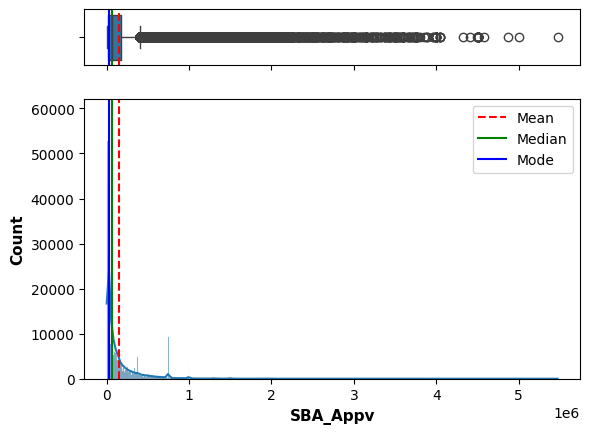

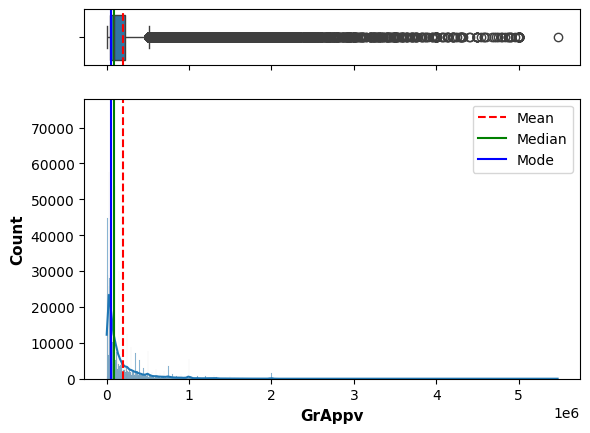

In [114]:
def hist_box_plot(col: str, df: pd.DataFrame, out: bool = False) -> None:
    """
    Display an histogram and a boxplot of df[col],
    col being a continuous numerical variable.
    `out` set to True allows to export the graph in .png format.
    """
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode().values[0]
     
    sns.boxplot(data=df, x=col, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')
     
    sns.histplot(data=df, x=col, ax=ax_hist, kde=True)
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
    ax_hist.axvline(median, color='g', linestyle='-', label="Median")
    ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
     
    ax_hist.legend(loc='best')
     
    # Set x-axis label
    ax_hist.set_xlabel(col, fontsize=11, fontweight='bold')

    # Set y-axis label for the histogram
    ax_hist.set_ylabel('Count', fontsize=11, fontweight='bold')

    # Clear the x-axis label for the boxplot (as they share the same x-axis)
    ax_box.set(xlabel='')

hist_box_plot("SBA_Appv", dataframe)
hist_box_plot("GrAppv", dataframe)

In [115]:
dataframe.GrAppv 

0          35000.0
1         229000.0
2         600000.0
3          70000.0
4         370000.0
            ...   
899159    160000.0
899160     90000.0
899161     55000.0
899162     50000.0
899163     50000.0
Name: GrAppv, Length: 897167, dtype: float64

#### Recession

In [116]:
dataframe.Recession.value_counts()

Recession
False    708049
True     189118
Name: count, dtype: int64

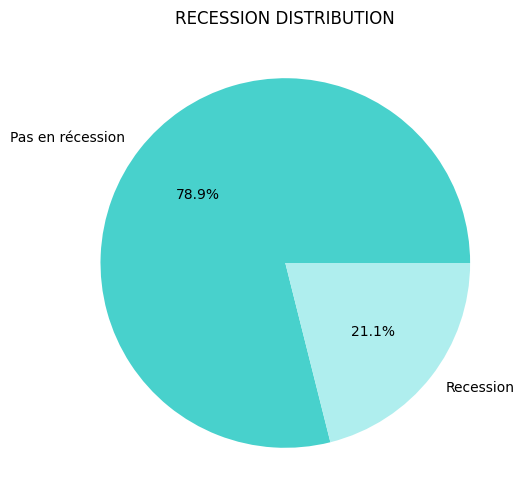

In [158]:
labels = ["Pas en récession", "Recession"]
colors = ["mediumturquoise", "paleturquoise"]
plt.figure(figsize=(10,6))

plt.pie(dataframe.Recession.value_counts(), labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("RECESSION DISTRIBUTION")
plt.show()

In [118]:
dataframe.Recession.describe()

count     897167
unique         2
top        False
freq      708049
Name: Recession, dtype: object

#### TARGET

In [119]:
dataframe.MIS_Status.describe()

count     897167
unique         2
top        P I F
freq      739609
Name: MIS_Status, dtype: object

In [120]:
dataframe.MIS_Status.isnull().sum()

0

In [121]:
dataframe.MIS_Status.value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

In [122]:
def encode_PIF(s: "object") -> str:
    if s == "P I F":
        return "PIF"
    return s

dataframe.MIS_Status = dataframe.MIS_Status.map(encode_PIF)
dataframe.MIS_Status.value_counts()

MIS_Status
PIF       739609
CHGOFF    157558
Name: count, dtype: int64

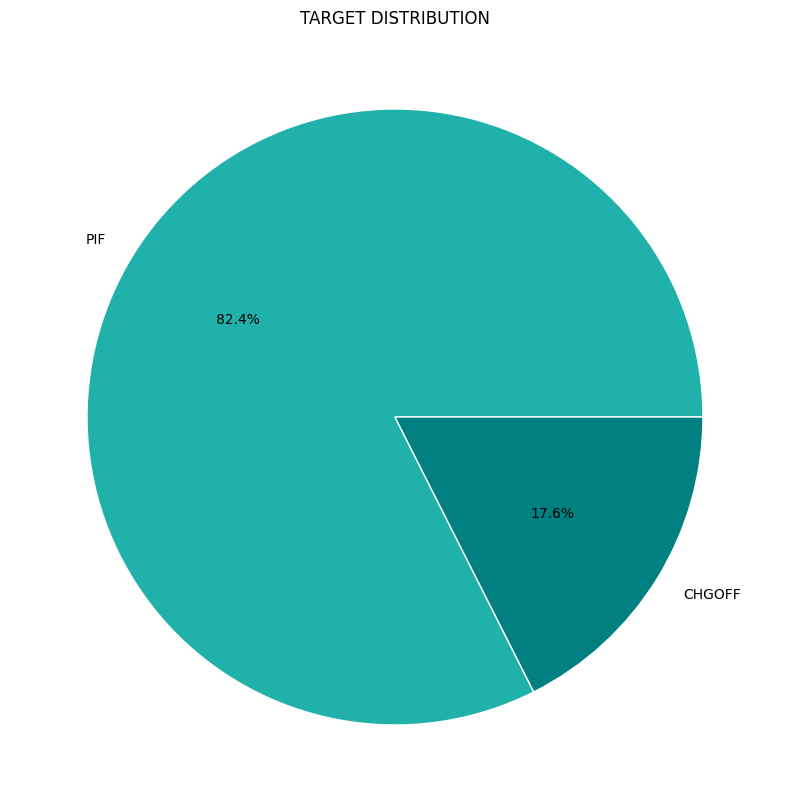

In [171]:
plt.figure(figsize=(10,10))
labels = ["PIF", "CHGOFF"]
colors = ["lightseagreen", "teal"]
plt.title("TARGET DISTRIBUTION")
plt.pie(dataframe.MIS_Status.value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', wedgeprops={'edgecolor':'white'})
plt.show()

#### SAMESTATE

In [124]:
dataframe.SameState.value_counts() 

SameState
True     473425
False    423742
Name: count, dtype: int64

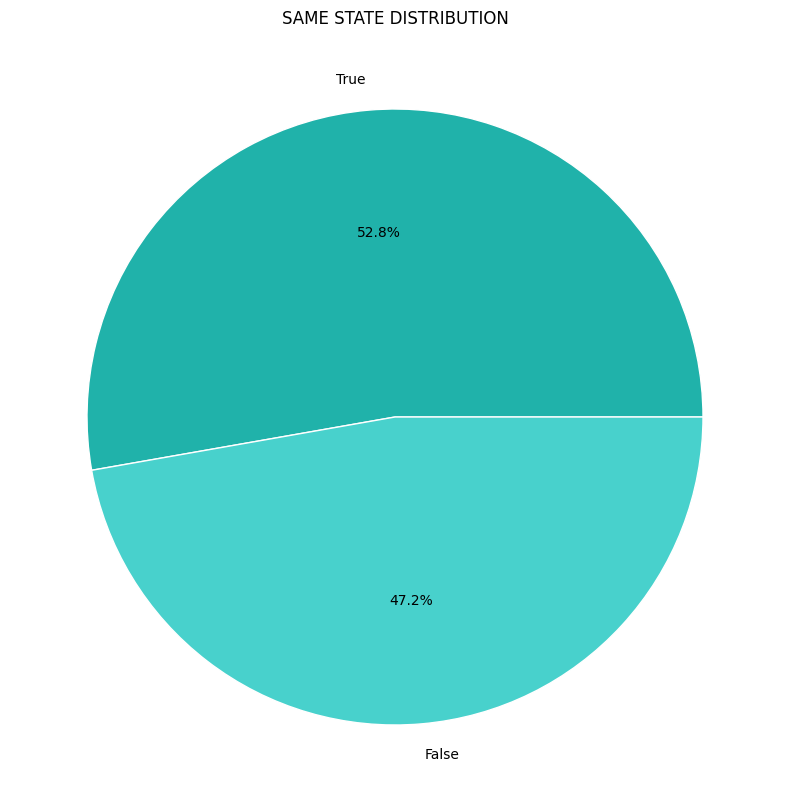

In [172]:
plt.figure(figsize=(10,10))
labels = ["True", "False"]
colors = ["lightseagreen", "mediumturquoise"]
plt.title("SAME STATE DISTRIBUTION")
plt.pie(dataframe.SameState.value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', wedgeprops={'edgecolor':'white'})
plt.show()

In [126]:
dataframe.columns

Index(['Name', 'State', 'Bank', 'BankState', 'NAICS', 'ApprovalFY', 'Term',
       'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode',
       'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv',
       'ApprovalMonth', 'ApprovalDay', 'ApprovalDoW', 'ApprovalYear',
       'Recession', 'NAICS_id', 'Description', 'SameState'],
      dtype='object')

#### TESTS MAISON

In [127]:
# pip install geopandas matplotlib

In [128]:
# pip install plotly

In [129]:
import plotly.express as px 
df = dataframe.copy()
df = df.groupby('State').count().reset_index()
df = df[["State", "BankState"]]
df = df.rename(columns={'BankState':'Total loan applications made'})

fig = px.choropleth(df,
                    locations='State',
                    locationmode='USA-states',
                    scope="usa",
                    color='Total loan applications made',
                    hover_name = 'State',
                    hover_data = 'Total loan applications made',
                    range_color=[0,120000],
                    color_continuous_scale='viridis',
                    title='NUMBER OF LOAN APPLICATIONS MADE BY EACH STATE ACROSS THE YEARS')
# fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [130]:
import plotly.express as px 
df = dataframe.copy()
df = df.groupby(['State', 'ApprovalYear'],).count().sort_values(by='ApprovalYear', ascending=True).reset_index()
df = df[["State", "BankState", 'ApprovalYear']]
df = df.rename(columns={'BankState':'Total loan applications made'})

fig = px.choropleth(df,
                    locations='State',
                    locationmode='USA-states',
                    scope="usa",
                    color='Total loan applications made',
                    hover_name = 'State',
                    hover_data = 'Total loan applications made',
                    animation_frame='ApprovalYear',
                    color_continuous_scale='VIRIDIS',
                    title='NUMBER OF LOAN APPLICATIONS MADE BY EACH STATE YEAR BY YEAR')
# fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=800, height=800)
fig.show()

c:\Users\Thibaut\Documents\SIMPLON\DEV-IA\projet_ML_classification_predictions_prets\loan_approval\.venv\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [175]:
import plotly.express as px 
df = dataframe.copy()
filtre_target = df["MIS_Status"] == "PIF"
df2 = df[filtre_target]
df2 = df2.groupby(['State', 'ApprovalYear'],).count().sort_values(by='ApprovalYear', ascending=True).reset_index()
df2 = df2[["State", "BankState", 'ApprovalYear']]
df2 = df2.rename(columns={'BankState':'Total loans paid back in full'})

fig = px.choropleth(df2,
                    locations='State',
                    locationmode='USA-states',
                    scope="usa",
                    color='Total loans paid back in full',
                    hover_name = 'State',
                    hover_data = 'Total loans paid back in full',
                    animation_frame='ApprovalYear',
                    color_continuous_scale='plasma',
                    title='NUMBER OF LOANS PAID BACK IN FULL OVER TIME')
# fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=800, height=600)
fig.update_layout(title_text='NUMBER OF LOANS PAID BACK IN FULL ACROSS THE YEARS', title_x=0.5)
#fig.add_annotation(text='Note: Ajoutez des annotations ici.', x=0.5, y=-0.1, showarrow=False, font=dict(size=10))
fig.show()

c:\Users\Thibaut\Documents\SIMPLON\DEV-IA\projet_ML_classification_predictions_prets\loan_approval\.venv\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [132]:
import plotly.express as px 
df = dataframe.copy()
filtre_target = df["MIS_Status"] == "P I F"
df2 = df[~filtre_target]
df2 = df2.groupby(['State', 'ApprovalYear'],).count().sort_values(by='ApprovalYear', ascending=True).reset_index()
df2 = df2[["State", "BankState", 'ApprovalYear']]
df2 = df2.rename(columns={'BankState':'Number of loans not paid back'})

fig = px.choropleth(df2,
                    locations='State',
                    locationmode='USA-states',
                    scope="usa",
                    color='Number of loans not paid back',
                    hover_name = 'State',
                    hover_data = 'Number of loans not paid back',
                    animation_frame='ApprovalYear',
                    color_continuous_scale='viridis',
                    title='NUMBER OF LOANS THAT HAVE NOT BEEN PAID BACK')
# fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=800, height=600)
fig.show()

c:\Users\Thibaut\Documents\SIMPLON\DEV-IA\projet_ML_classification_predictions_prets\loan_approval\.venv\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# MACHINE LEARNING

### PYCARET

In [133]:
#pip install pycaret

In [134]:
# from pycaret.classification import *
# df_test = data.copy()
# df_test = df_test.dropna()
# session = setup(data=dataframe, target='MIS_Status', normalize=True, train_size=0.8, fold=3, data_split_stratify=True, session_id=0)

In [135]:
# algo = models()
# print(algo)

In [136]:
# from pycaret.classification import compare_models
# top_models = compare_models(sort="Recall")
# print(top_models)